# XGBoost on GPU, no categories, with dates, including "onetimers"
## Predicting the time difference to the next repurchase

### Methods & Settings

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import gc
import joblib

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

pd.set_option('display.max_rows', 250)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 50)

####
# prints memory usage
def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB\n'.format(start_mem))
    return

####
# seperates features from label (y must be last column)
def sep_X_y(df_train, df_test):
    X_train = df_train.iloc[:,0:-1] # extracts all rows [:] and columns from 0 to next-to-last [0:-1]
    y_train = df_train.iloc[:,-1] # extracts all rows [:] and only last column [-1]
    X_test = df_test.iloc[:,0:-1]
    y_test = df_test.iloc[:,-1]
    
    return [X_train, y_train, X_test, y_test]

####
# split training and test set from given dataframe with dates as boundaries
def dt_train_test_split(df, dt_start_train, dt_end_train, dt_start_test, dt_end_test):
    print('Splitting dataframe...\n')
    
    # get indices from desired boundaries
    idx_start_train = df.date.searchsorted(pd.to_datetime(dt_start_train), side='left') # list needs to be sorted already for searchsorted
    idx_end_train = df.date.searchsorted(pd.to_datetime(dt_end_train) + pd.Timedelta(days=1), side='left')
    idx_start_test = df.date.searchsorted(pd.to_datetime(dt_start_test), side='left')
    idx_end_test = df.date.searchsorted(pd.to_datetime(dt_end_test) + pd.Timedelta(days=1), side='left')
    
    train = df.iloc[idx_start_train:idx_end_train]
    test = df.iloc[idx_start_test:idx_end_test]
    
    train.drop(columns=['date'], axis=0, inplace=True)
    test.drop(columns=['date'], axis=0, inplace=True)
    
    return sep_X_y(train, test)

####
# trains XGB model (classifier)
def train_xgb(X, y):
    X_train = X
    y_train = y
    
    
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
    fitted_model = model.fit(X_train, y_train)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain')
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

def train_xgb_bestHyper(X, y):
    X_train = X
    y_train = y
    space = best_hyperparams
    
    print('Fitting model...\n')
    model = XGBRegressor(tree_method='gpu_hist', gpu_id=0,
                    eta = space['eta'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    fitted_model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    xgb.plot_importance(model, importance_type='gain')
    plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

def train_dtc(X, y):
    X_train = X
    y_train = y
    
    print('Fitting model...\n')
    model = DecisionTreeRegressor()
    fitted_model = model.fit(X_train, y_train)
    
    print('Plotting feature importance for "gain". Do not rely on that.\n')
    print('https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27\n')
    #xgb.plot_importance(model, importance_type='gain')
    #plt.show()
    
    # GRAPHVIZ (software + pip package) needed for tree plotting
    #fig, ax = plt.subplots(figsize=(30, 30))
    #xgb.plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
    #plt.show()
    
    return fitted_model

####
# predicts labels of training and test with given model
def predict_values(model, X_train, y_train, X_test, y_test):
    print('Predicting values...\n')
    # predict y values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    
    # get accuracies
    model_train = mean_squared_error(y_train, y_train_pred)
    model_test = mean_squared_error(y_test, y_test_pred)
    
    
    """
    #get precision
    model_train_precision = precision_score(y_train, y_train_pred, average)
    model_test_precision = precision_score(y_test, y_test_pred)
    """
    # print info about accuracies
    print(f'\n XGboost train/test rmse: '
         f'{model_train:.3f}/{model_test:.3f}')
    
    # return predicted values
    return [y_train_pred, y_test_pred]

def predict_values_train(model, X_train, y_train):
    print('Predicting values...\n')
    # predict y values
    y_train_pred = model.predict(X_train)

    # get accuracies
    model_train = mean_squared_error(y_train, y_train_pred)
    
    
    """
    #get precision
    model_train_precision = precision_score(y_train, y_train_pred, average)
    model_test_precision = precision_score(y_test, y_test_pred)
    """
    # print info about accuracies
    print(f'\n XGboost train'
         f'{model_train:.3f}')
    
    # return predicted values
    return y_train_pred

####
# concatenates prediction with actual target for evaluation
def evaluate_pred(X, y, y_pred):
    # create dataframe from test-prediction with index from X_test
    df_y_pred = pd.DataFrame(y_pred, columns=['nextBuyIn_pred'], index=X.index, dtype=np.int8)

    # concatenate X, y, y_pred (put columns next to each other)
    df_eval = pd.concat([X, y, df_y_pred], axis=1)
    
    return df_eval

####
# executes all needed functions of the above with given training and test data and provided train method
def execute_pipeline(train_method, df, list_of_four_df_boundaries):
    b = list_of_four_df_boundaries
    # split dataframe in train/test and X/y
    X_train, y_train, X_test, y_test = dt_train_test_split(df, b[0], b[1], b[2], b[3])
    
    #train model
    model = train_method(X_train, y_train)    
    
    # make predictions
    pred_train, pred_test = predict_values(model, X_train, y_train, X_test, y_test)
    
    print('\nExecuted pipeline.\nEvaluate with "evaluate_pred(X, y, y_pred)"\n')
    return [pred_train, pred_test, X_train, y_train, X_test, y_test]

In [2]:
file = r'C:\Users\LEAND\Coding\Jupyter Notebooks\csv\220623_complete_feature-list_orderhistory_trainingOhneNull.csv' # scores calculated with data from jun-oct

columns = [#'date',
           'userID', 
           'itemID',
           'order', 
           'brand', 
           'feature_1', 
           'feature_2', 
           'feature_3', 
           'feature_4', 
           'feature_5',
           'brandOrderRatio',
           'feature1OrderRatio',
           'feature2OrderRatio',
           'feature3OrderRatio',
           'feature4OrderRatio',
           'feature5OrderRatio',
           'TotalBFscore',
           'RCP',
           'MeanDiffToNxt(user)',
           'TotalItemOrders(user)',
           #'TotalItemOrders(item)',
           'date(year)',
           'date(month)',
           'date(weekOfMonth)',
           'date(dayOfMonth)',
           'date(weekOfYear)',
           'date(dayOfYear)',
           #'nextBuyInWeeks(round)', # label
           'nextBuyInWeeks(floor)', # label
           #'nextBuyInWeekOfYear' # label; schlechte idee
          ]

dtype = {'userID':np.uint16,
         'itemID':np.uint16,
         'order':np.uint8,
         'brand':np.int16,
         'feature_1':np.int8,
         'feature_2':np.uint8,
         'feature_3':np.int16,
         'feature_4':np.int8,
         'feature_5':np.int16}

---

# Predicting Weeks

## Preparation

In [3]:
df = pd.read_csv(file, usecols=columns, sep='|', dtype=dtype, nrows=None, converters={'date':pd.to_datetime})

show_mem_usage(df)
df.head()

Memory usage of dataframe is 24.55 MB



,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor)
0,76,23050,1,1411,4,0,22,0,151,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2,169.0,2020,6,1,1,23,153,24
1,116,9408,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3,114.5,2020,6,1,1,23,153,22
2,116,25677,1,322,4,0,536,0,144,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3,114.5,2020,6,1,1,23,153,22
3,135,13660,1,157,4,0,513,0,137,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2,32.0,2020,6,1,1,23,153,4
4,135,22174,1,504,10,0,441,3,84,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3,40.5,2020,6,1,1,23,153,4


In [34]:
column_headers = list(df.columns)
column_headers

['userID',
 'itemID',
 'order',
 'brand',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'brandOrderRatio',
 'feature1OrderRatio',
 'feature2OrderRatio',
 'feature3OrderRatio',
 'feature4OrderRatio',
 'feature5OrderRatio',
 'TotalBFscore',
 'RCP',
 'TotalItemOrders(user)',
 'MeanDiffToNxt(user)',
 'date(year)',
 'date(month)',
 'date(weekOfMonth)',
 'date(dayOfMonth)',
 'date(weekOfYear)',
 'date(dayOfYear)',
 'nextBuyInWeeks(floor)']

## Training & Prediction

Pipeline needs training method, dataframe and dates to split dataframe in training and test set.

In [5]:
X_train = df.iloc[:,:-1]
y_train = df.iloc[:,-1]

scaler_X = MinMaxScaler()
#scaler_y = MinMaxScaler()

X_train_nrm = scaler_X.fit_transform(X_train)
#y_train_nrm = scaler_y.fit_transform(y_train)

#df_normalized = pd.DataFrame(df_normalized)
#df_normalized.set_axis(column_headers, axis=1,inplace=True)
#df_normalized
X_train_nrm

array([[0.0016473 , 0.70337819, 0.        , ..., 0.        , 0.42307692,
        0.41643836],
       [0.00251431, 0.2870701 , 0.        , ..., 0.        , 0.42307692,
        0.41643836],
       [0.00251431, 0.78354542, 0.        , ..., 0.        , 0.42307692,
        0.41643836],
       ...,
       [0.466382  , 0.59330465, 0.        , ..., 0.76666667, 0.03846154,
        0.0630137 ],
       [0.78142882, 0.70636882, 0.        , ..., 0.76666667, 0.03846154,
        0.0630137 ],
       [0.97409832, 0.03576551, 0.        , ..., 0.76666667, 0.03846154,
        0.0630137 ]])

In [8]:
X_train = pd.DataFrame(X_train_nrm)
X_train.set_axis(column_headers[:-1], axis=1,inplace=True)
X_train

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear)
0,0.001647,0.703378,0.0,0.932584,0.454545,0.000000,0.042672,0.2,0.795812,0.170847,1.000000,1.000000,0.135717,1.00000,0.217280,0.940897,0.255945,0.000000,0.688797,0.0,0.454545,0.2,0.000000,0.423077,0.416438
1,0.002514,0.287070,0.0,0.212822,0.454545,0.000000,0.996289,0.2,0.759162,0.265774,1.000000,1.000000,0.543643,1.00000,1.000000,0.988336,0.035556,0.002049,0.462656,0.0,0.454545,0.2,0.000000,0.423077,0.416438
2,0.002514,0.783545,0.0,0.212822,0.454545,0.000000,0.996289,0.2,0.759162,0.265774,1.000000,1.000000,0.543643,1.00000,1.000000,0.988336,0.203472,0.002049,0.462656,0.0,0.454545,0.2,0.000000,0.423077,0.416438
3,0.002926,0.416827,0.0,0.103767,0.454545,0.000000,0.953618,0.2,0.722513,0.224108,1.000000,1.000000,0.071964,1.00000,0.059728,0.933540,0.051183,0.000000,0.120332,0.0,0.454545,0.2,0.000000,0.423077,0.416438
4,0.002926,0.676646,0.0,0.333113,1.000000,0.000000,0.820037,0.8,0.445026,0.122258,0.790795,1.000000,0.082380,0.52263,0.587373,0.757337,0.452020,0.002049,0.155602,0.0,0.454545,0.2,0.000000,0.423077,0.416438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171588,0.422273,0.054350,0.0,0.003966,0.454545,1.000000,0.597403,0.2,0.759162,0.483508,1.000000,0.050417,0.197150,1.00000,1.000000,0.607925,0.122522,0.010246,0.120332,1.0,0.000000,0.6,0.766667,0.038462,0.063014
171589,0.466382,0.018096,0.0,0.134171,0.454545,0.333333,0.912801,0.2,0.350785,0.009187,1.000000,0.104368,0.601176,1.00000,0.419063,0.606568,0.665123,0.010246,0.084025,1.0,0.000000,0.6,0.766667,0.038462,0.063014
171590,0.466382,0.593305,0.0,0.269663,1.000000,0.000000,0.298701,0.2,0.204188,0.233151,0.790795,1.000000,0.014103,1.00000,0.075256,0.885075,0.222834,0.012295,0.112626,1.0,0.000000,0.6,0.766667,0.038462,0.063014
171591,0.781429,0.706369,0.0,0.925975,0.454545,0.000000,0.270872,0.2,0.858639,0.077304,1.000000,1.000000,0.029678,1.00000,0.204021,0.934988,0.247900,0.004098,0.294606,1.0,0.000000,0.6,0.766667,0.038462,0.063014


In [9]:
y_train

0         24
1         22
2         22
3          4
4          4
          ..
171588     1
171589     1
171590     1
171591     1
171592     1
Name: nextBuyInWeeks(floor), Length: 171593, dtype: int64

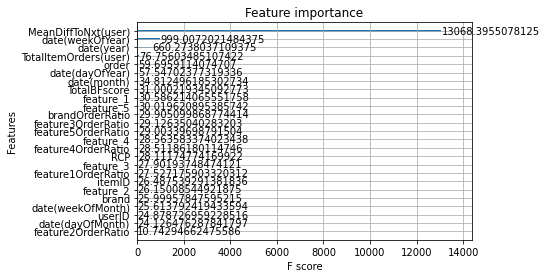

In [26]:
model = XGBRegressor(tree_method='gpu_hist', gpu_id=0)
fitted_model = model.fit(X_train, y_train)

xgb.plot_importance(model, importance_type='gain')
plt.show()

In [32]:
y_train_pred = model.predict(X_train)
y_train_pred = np.array([round(i) for i in y_train_pred]) 
y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred

,0
0,24
1,20
2,20
3,4
4,5
...,...
171588,1
171589,2
171590,2
171591,1


In [29]:
model_train = mean_squared_error(X_train, y_train_pred)

# print info about accuracies
print(f'\n XGboost train '
     f'{model_train:.3f}')
y_train_pred

ValueError: y_true and y_pred have different number of output (25!=1)

In [86]:
df_y_pred = pd.DataFrame(y_train_pred, columns=['nextBuyIn_pred'], index=X_train.index)
# concatenate X, y, y_pred (put columns next to each other)
df_eval_train = pd.concat([X_train, y_train, df_y_pred], axis=1)
df_eval_train

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,brandOrderRatio,feature1OrderRatio,feature2OrderRatio,feature3OrderRatio,feature4OrderRatio,feature5OrderRatio,TotalBFscore,RCP,TotalItemOrders(user),MeanDiffToNxt(user),date(year),date(month),date(weekOfMonth),date(dayOfMonth),date(weekOfYear),date(dayOfYear),nextBuyInWeeks(floor),nextBuyIn_pred
0,0.001647,0.703378,0.000000,0.932584,0.454545,0.000000,0.042672,0.2,0.795812,0.170847,1.000000,1.000000,0.135717,1.00000,0.217280,0.940897,0.255945,0.000000,0.688797,0.0,0.454545,0.2,0.000000,0.423077,0.416438,0.696970,0.723664
1,0.002514,0.287070,0.000000,0.212822,0.454545,0.000000,0.996289,0.2,0.759162,0.265774,1.000000,1.000000,0.543643,1.00000,1.000000,0.988336,0.035556,0.002049,0.462656,0.0,0.454545,0.2,0.000000,0.423077,0.416438,0.636364,0.555153
2,0.002514,0.783545,0.000000,0.212822,0.454545,0.000000,0.996289,0.2,0.759162,0.265774,1.000000,1.000000,0.543643,1.00000,1.000000,0.988336,0.203472,0.002049,0.462656,0.0,0.454545,0.2,0.000000,0.423077,0.416438,0.636364,0.533073
3,0.002926,0.416827,0.000000,0.103767,0.454545,0.000000,0.953618,0.2,0.722513,0.224108,1.000000,1.000000,0.071964,1.00000,0.059728,0.933540,0.051183,0.000000,0.120332,0.0,0.454545,0.2,0.000000,0.423077,0.416438,0.090909,0.099386
4,0.002926,0.676646,0.000000,0.333113,1.000000,0.000000,0.820037,0.8,0.445026,0.122258,0.790795,1.000000,0.082380,0.52263,0.587373,0.757337,0.452020,0.002049,0.155602,0.0,0.454545,0.2,0.000000,0.423077,0.416438,0.090909,0.139552
5,0.004378,0.822088,0.000000,0.831461,0.454545,0.000000,0.905380,0.8,0.235602,0.026220,1.000000,1.000000,0.384965,0.52263,0.686971,0.816166,0.119811,0.002049,0.307054,0.0,0.454545,0.2,0.000000,0.423077,0.416438,0.303030,0.289302
6,0.005202,0.223290,0.000000,0.882353,0.636364,0.000000,0.782931,0.8,0.036649,0.011841,0.326553,1.000000,0.347627,0.52263,0.023258,0.633827,0.276235,0.000000,0.282158,0.0,0.454545,0.2,0.000000,0.423077,0.416438,0.272727,0.243110
7,0.005202,0.813086,0.000000,0.428288,1.000000,0.000000,0.666048,0.8,0.130890,0.037037,0.790795,1.000000,0.151113,0.52263,0.050124,0.735008,0.102302,0.000000,0.282158,0.0,0.454545,0.2,0.000000,0.423077,0.416438,0.272727,0.260043
8,0.005289,0.315542,0.000000,0.677462,0.636364,0.000000,0.369202,0.2,0.094241,0.045373,0.326553,1.000000,0.013816,1.00000,0.916287,0.810581,0.225416,0.002049,0.439834,0.0,0.454545,0.2,0.000000,0.423077,0.416438,0.424242,0.449554
9,0.005982,0.478074,0.000000,0.793787,0.454545,0.000000,0.057514,0.2,0.858639,0.277413,1.000000,1.000000,0.025196,1.00000,0.204021,0.939354,0.134336,0.012295,0.202282,0.0,0.454545,0.2,0.000000,0.423077,0.416438,0.212121,0.172167


In [92]:
eval_denorm = scaler.inverse_transform(df_eval_train.iloc[:,:-1])
df_eval_denorm = pd.DataFrame(eval_denorm)
df_eval_denorm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,76.0,23050.0,1.0,1411.0,4.0,0.0,22.0,0.0,151.0,0.007899,0.466804,0.826492,0.008540,0.640224,0.018705,0.940897,0.259374,2.0,169.000000,2020.0,6.0,1.0,1.0,23.0,153.0,24.0
1,116.0,9408.0,1.0,322.0,4.0,0.0,536.0,0.0,144.0,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.040000,3.0,114.500000,2020.0,6.0,1.0,1.0,23.0,153.0,22.0
2,116.0,25677.0,1.0,322.0,4.0,0.0,536.0,0.0,144.0,0.012288,0.466804,0.826492,0.034208,0.640224,0.086085,0.988336,0.207143,3.0,114.500000,2020.0,6.0,1.0,1.0,23.0,153.0,22.0
3,135.0,13660.0,1.0,157.0,4.0,0.0,513.0,0.0,137.0,0.010361,0.466804,0.826492,0.004528,0.640224,0.005142,0.933540,0.055556,2.0,32.000000,2020.0,6.0,1.0,1.0,23.0,153.0,4.0
4,135.0,22174.0,1.0,504.0,10.0,0.0,441.0,3.0,84.0,0.005653,0.369146,0.826492,0.005184,0.334600,0.050564,0.757337,0.454545,3.0,40.500000,2020.0,6.0,1.0,1.0,23.0,153.0,4.0
5,202.0,26940.0,1.0,1258.0,4.0,0.0,487.0,3.0,44.0,0.001213,0.466804,0.826492,0.024224,0.334600,0.059138,0.816166,0.123867,3.0,77.000000,2020.0,6.0,1.0,1.0,23.0,153.0,11.0
6,240.0,7318.0,1.0,1335.0,6.0,0.0,421.0,3.0,6.0,0.000549,0.152436,0.826492,0.021874,0.334600,0.002002,0.633827,0.279570,2.0,71.000000,2020.0,6.0,1.0,1.0,23.0,153.0,10.0
7,240.0,26645.0,1.0,648.0,10.0,0.0,358.0,3.0,24.0,0.001713,0.369146,0.826492,0.009509,0.334600,0.004315,0.735008,0.106439,2.0,71.000000,2020.0,6.0,1.0,1.0,23.0,153.0,10.0
8,244.0,10341.0,1.0,1025.0,6.0,0.0,198.0,0.0,17.0,0.002099,0.152436,0.826492,0.000869,0.640224,0.078879,0.810581,0.228986,3.0,109.000000,2020.0,6.0,1.0,1.0,23.0,153.0,15.0
9,276.0,15667.0,1.0,1201.0,4.0,0.0,30.0,0.0,163.0,0.012826,0.466804,0.826492,0.001585,0.640224,0.017563,0.939354,0.138325,8.0,51.750000,2020.0,6.0,1.0,1.0,23.0,153.0,8.0


## XGBoost

### Evaluation

In [87]:
rowcount = len(df_eval_train)
should = len(df_eval_train.loc[(df_eval_train['nextBuyInWeeks(floor)'] != 0)])
is_ = len(df_eval_train.loc[(df_eval_train['nextBuyInWeeks(floor)'] != 0) & (df_eval_train['nextBuyInWeeks(floor)'] == df_eval_train.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is not 0)')

row count of set:					 171593
rows where label is not 0:				 166619 	 (97.101 % of all rows in set)
rows where label was predicted correctly AND not 0:	 0 	 (0.000 % of rows where label is not 0)


In [88]:
rowcount = len(df_eval_train)
should = rowcount
is_ = len(df_eval_train.loc[(df_eval_train['nextBuyInWeeks(floor)'] == df_eval_train.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t {rowcount}')
print(f'rows where label was predicted correctly:\t {is_} \t ({is_/should*100:.3f} % of rows)')

row count of set:				 171593
rows where label was predicted correctly:	 0 	 (0.000 % of rows)


---

## Decision Tree

In [17]:
%%time
#dtc
pred_train, pred_test, X_train, y_train, X_test, y_test = execute_pipeline(train_dtc, df, [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
])

Splitting dataframe...

Fitting model...

Plotting feature importance for "gain". Do not rely on that.

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

Predicting values...


 XGboost train/test accuracies: 0.020/17.665

Executed pipeline.
Evaluate with "evaluate_pred(X, y, y_pred)"

CPU times: total: 3.34 s
Wall time: 3.34 s


### Evaluation

#### train set

In [18]:
df_eval_train = evaluate_pred(X_train, y_train, pred_train)

#### test set

In [19]:
df_eval_test = evaluate_pred(X_test, y_test, pred_test)

In [20]:
rowcount = len(df_eval_test)
should = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0)])
is_ = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0) & (df_eval_test.nextBuyInWeeks == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is actually 0)')

row count of set:					 130779
rows where label is not 0:				 16091 	 (12.304 % of all rows in set)
rows where label was predicted correctly AND not 0:	 516 	 (3.207 % of rows where label is actually 0)


## Hyperparameter Tuning

In [49]:
!pip install hyperopt

  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=e9ee614eafe78c4e768188ae79215eb60d1e7738ab67a895e712001dd53ab0ee
  Stored in directory: c:\users\leand\appdata\local\pip\cache\wheels\22\73\06\557dc4f4ef68179b9d763930d6eec26b88ed7c389b19588a1c
Successfully built future


In [50]:
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space = {
        'eta': hp.quniform('eta', 0.01, 0.5, 0.01),
        'max_depth': hp.quniform('max_depth', 3, 5, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 1000,
        'seed': 0
    }

In [53]:
def objective(space):
    reg=xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0,
                    eta = space['eta'],
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),
                    n_estimators = space['n_estimators'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    reg.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    pred = reg.predict(X_test)
    loss = mean_squared_error(y_test, pred)
    print ("LOSS:", loss)
    return {'loss': loss, 'status': STATUS_OK }

In [54]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 1000,
                        trials = trials)

LOSS:                                                                                                                  
7.259098485135326                                                                                                      
LOSS:                                                                                                                  
5.9393654983792805                                                                                                     
LOSS:                                                                                                                  
9.943502864855471                                                                                                      
LOSS:                                                                                                                  
5.937102402336671                                                                                                      
LOSS:                                   

LOSS:                                                                                                                  
19.334005759740865                                                                                                     
LOSS:                                                                                                                  
5.952195508400986                                                                                                      
LOSS:                                                                                                                  
5.993206689659181                                                                                                      
LOSS:                                                                                                                  
5.961315816329838                                                                                                      
LOSS:                                   

LOSS:                                                                                                                  
5.954776784448804                                                                                                      
LOSS:                                                                                                                  
5.956179629222112                                                                                                      
LOSS:                                                                                                                  
5.924005015168141                                                                                                      
LOSS:                                                                                                                  
5.946202522284125                                                                                                      
LOSS:                                   

LOSS:                                                                                                                  
5.958166588569138                                                                                                      
LOSS:                                                                                                                  
5.967587800167442                                                                                                      
LOSS:                                                                                                                  
5.950963228265492                                                                                                      
LOSS:                                                                                                                  
5.989573305347509                                                                                                      
LOSS:                                   

LOSS:                                                                                                                  
5.937861075499296                                                                                                      
LOSS:                                                                                                                  
5.98305549708962                                                                                                       
LOSS:                                                                                                                  
5.9341355694397615                                                                                                     
LOSS:                                                                                                                  
5.9351789339826695                                                                                                     
LOSS:                                   

LOSS:                                                                                                                  
8.169121153078605                                                                                                      
LOSS:                                                                                                                  
6.002713380037092                                                                                                      
LOSS:                                                                                                                  
5.9357353685296195                                                                                                     
LOSS:                                                                                                                  
5.956078430277108                                                                                                      
LOSS:                                   

LOSS:                                                                                                                  
5.943000912774027                                                                                                      
LOSS:                                                                                                                  
5.946918691172277                                                                                                      
LOSS:                                                                                                                  
5.927484778548702                                                                                                      
LOSS:                                                                                                                  
5.93293682503515                                                                                                       
LOSS:                                   

KeyboardInterrupt: 

In [43]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7567134474205279, 'eta': 0.05, 'gamma': 2.8721332723619244, 'max_depth': 5.0, 'min_child_weight': 8.0, 'reg_alpha': 171.0, 'reg_lambda': 0.32452326405309345}


In [44]:
type(best_hyperparams)

dict

## XGBoost mit optimierten Hyperparametern

In [54]:
%%time
pred_train, pred_test, X_train, y_train, X_test, y_test = execute_pipeline(train_xgb_bestHyper, df, [
    '2020-06-01', # start train set
    '2020-10-31', # end train set
    '2020-11-01', # start test set
    '2020-11-30'  # end test set
])

Splitting dataframe...

Fitting model...



NameError: name 'fitted_model' is not defined

### Evaluation

#### train set

In [18]:
df_eval_train = evaluate_pred(X_train, y_train, pred_train)

#### test set

In [19]:
df_eval_test = evaluate_pred(X_test, y_test, pred_test)

In [20]:
rowcount = len(df_eval_test)
should = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0)])
is_ = len(df_eval_test.loc[(df_eval_test.nextBuyInWeeks != 0) & (df_eval_test.nextBuyInWeeks == df_eval_test.nextBuyIn_pred)]) 

print(f'row count of set:\t\t\t\t\t {rowcount}')
print(f'rows where label is not 0:\t\t\t\t {should} \t ({should/rowcount*100:.3f} % of all rows in set)')
print(f'rows where label was predicted correctly AND not 0:\t {is_} \t ({is_/should*100:.3f} % of rows where label is actually 0)')

row count of set:					 130779
rows where label is not 0:				 16091 	 (12.304 % of all rows in set)
rows where label was predicted correctly AND not 0:	 516 	 (3.207 % of rows where label is actually 0)
